In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
"""
Data Management
"""
data = pd.read_csv("/Users/Rohit/Desktop/outlook.csv")

#upper-case all DataFrame column names
data.columns = map(str.upper, data.columns)

# Data Management
data_clean = data.dropna()

In [3]:
#W1_A2: How much have you thought about the upcoming election for president?
#W1_A10: How often, if ever, do you discuss politics with your family or friends?
#W1_A11: How many days in the past week did you watch national news programs on television or on the Internet?
#W1_A12: Do you approve or disapprove of the way Barack Obama is handling his job as President?
#W1_B2: How much can people like you affect what the government does?

cluster=data_clean[['W1_A2', 'W1_A10', 'W1_A11', 'W1_A12', 'W1_B1']]
cluster.describe()

,W1_A2,W1_A10,W1_A11,W1_A12,W1_B1
count,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000
mean,2.130017,2.678010,4.192845,1.239965,3.599913
std,1.210902,1.227214,2.624862,0.578239,1.143200
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,2.000000,2.000000,1.000000,3.000000
50%,2.000000,2.000000,4.000000,1.000000,4.000000
75%,3.000000,4.000000,7.000000,2.000000,4.000000
max,5.000000,5.000000,8.000000,2.000000,5.000000


In [4]:
# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()
#clustervar['W1_A1']=preprocessing.scale(clustervar['W1_A1'].astype('float64'))
clustervar['W1_A2']=preprocessing.scale(clustervar['W1_A2'].astype('float64'))
clustervar['W1_A10']=preprocessing.scale(clustervar['W1_A10'].astype('float64'))
clustervar['W1_A11']=preprocessing.scale(clustervar['W1_A11'].astype('float64'))
clustervar['W1_A12']=preprocessing.scale(clustervar['W1_A12'].astype('float64'))
clustervar['W1_B1']=preprocessing.scale(clustervar['W1_B1'].astype('float64'))

In [5]:
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])


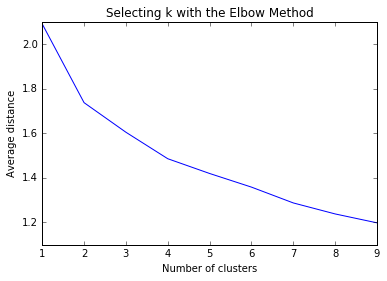

In [7]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
%matplotlib inline
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

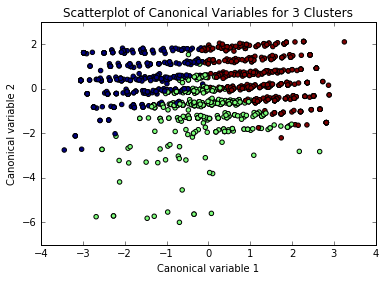

In [8]:
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)
# plot clusters

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [9]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

2    618
1    513
0    473
Name: cluster, dtype: int64

In [10]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index     W1_A2    W1_A10    W1_A11    W1_A12     W1_B1
cluster                                                               
0        1224.693446  1.151703 -0.819682 -0.804982  0.250493  0.547970
1        1142.483431 -0.195955 -0.301577 -0.339406 -0.560074 -0.707371
2        1095.655340 -0.710197  0.830843  0.847091  0.209088  0.132024


In [11]:
# validate clusters in training data by examining cluster differences in W1_A1 using ANOVA
# first have to merge W1_A1 with clustering variables and cluster assignment data 
gpa_data=data_clean['W1_A1']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['W1_A1', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula='W1_A1 ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                  W1_A1   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     529.7
Date:                Sun, 10 Jul 2016   Prob (F-statistic):          2.80e-177
Time:                        11:01:20   Log-Likelihood:                -2182.8
No. Observations:                1604   AIC:                             4372.
Df Residuals:                    1601   BIC:                             4388.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           3.7421      0.043     

In [12]:
print ('means for W1_A1 by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

means for W1_A1 by cluster
            W1_A1
cluster          
0        3.742072
1        2.672515
2        1.864078


In [13]:
print ('standard deviations for W1_A1 by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for W1_A1 by cluster
            W1_A1
cluster          
0        1.011096
1        1.020285
2        0.817735


In [14]:
mc1 = multi.MultiComparison(sub1['W1_A1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -1.0696  -1.2108 -0.9283  True 
  0      2     -1.878  -2.0134 -1.7426  True 
  1      2    -0.8084  -0.9408 -0.6761  True 
---------------------------------------------
